<a href="https://colab.research.google.com/github/abdulrahimq/audio-to-stress/blob/main/wav_to_vec_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -U openai-whisper
from whisper import audio
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.2/803.2 kB 9.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for openai-whisper: filename=openai_whisper-20250625-py3-none-any.whl size=803979 sha256=4a1eccb16d1a37e1c1f1008afd705e622d2e3d439ee5974475efc3950fa46279
  Stored in directory: /root/.cache/pip/wheels/61/d2/20/09ec9bef734d126cba375b15898010b6cc28578d8afdde5869
Successfully built openai-whisper


In [23]:
df = pd.read_csv("/content/Copy_of_South Levantine_wiktionary_ipa_3.csv")

In [24]:
df.info()
df.columns
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2782 entries, 0 to 2781
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   soundVec    0 non-null      float64
 1   ipa         2782 non-null   object 
 2   syllables   0 non-null      float64
 3   stress      0 non-null      float64
 4   audio_urls  2656 non-null   object 
dtypes: float64(3), object(2)
memory usage: 108.8+ KB


(2782, 5)

In [25]:
df.head(20)

,soundVec,ipa,syllables,stress,audio_urls
0,NaN,ʔāḵir<p:ʔæː.xɪr><p:ʔaː.xɪr>,NaN,NaN,https://upload.wikimedia.org/wikipedia/commons...
1,NaN,ʔāḵre<p:ˈʔæːx.re> ʔāḵra<p:ˈʔæːx.ra>,NaN,NaN,https://upload.wikimedia.org/wikipedia/commons...
2,NaN,ʔāḏār<p:ʔaˈðˤɑːrˤ><p:ʔaˈzˤɑːrˤ>,NaN,NaN,NaN
3,NaN,ʔāsef<p:ˈʔæː.sɪf>,NaN,NaN,https://upload.wikimedia.org/wikipedia/commons...
4,NaN,ʔāsya<p:ˈʔæːs.ja>,NaN,NaN,https://upload.wikimedia.org/wikipedia/commons...
5,NaN,ʔālāf<p:ʔaˈlæːf>,NaN,NaN,https://upload.wikimedia.org/wikipedia/commons...
6,NaN,ʔāle<p:ˈʔæː.le> ʔāla<p:ˈʔæː.la>,NaN,NaN,https://upload.wikimedia.org/wikipedia/commons...
7,NaN,ʔāman<p:ˈʔæː.man>,NaN,NaN,https://upload.wikimedia.org/wikipedia/commons...
8,NaN,ʔānas<p:ˈʔæː.nas>,NaN,NaN,https://upload.wikimedia.org/wikipedia/commons...
9,NaN,ʔā<p:ʔɑː>,NaN,NaN,https://upload.wikimedia.org/wikipedia/commons...


In [26]:
df['ipa']

,ipa
0,ʔāḵir<p:ʔæː.xɪr><p:ʔaː.xɪr>
1,ʔāḵre<p:ˈʔæːx.re> ʔāḵra<p:ˈʔæːx.ra>
2,ʔāḏār<p:ʔaˈðˤɑːrˤ><p:ʔaˈzˤɑːrˤ>
3,ʔāsef<p:ˈʔæː.sɪf>
4,ʔāsya<p:ˈʔæːs.ja>
...,...
2777,yahūd<p:jaˈhuːd>
2778,yahūdi<p:jaˈhuː.di>
2779,yōm<p:joːm>
2780,gīm<p:ɡiːm>


In [155]:
def clean_transcription(dataframe):
  """
  A function that takes the dataframe and cleans the ipa column.
  first holds all the strings between '<' and '>', deletes everything else, then
  removes every occurence of 'p',':', and '<'/'>' from the result, returning the
  raw ipa transcription. when there is more than one transcription, the first one is used by default.

  Additionally, three rules are used to exclude certain transcriptions from the data (2715). One is if
  the above algorithm does not find any transcription-(68) cases where there were no transcriptions
  inside the described markers- it is excluded. secondly, if the transcription contains the syllable marker
  indicated, but does not contain a stress marker, we assume it is a corrupted data and remove (43) cases. We
  are left with (2604) cases. Finally, all cases where we have more than one stress marker, and hence are unable
  to unabmibuguate between the location of the stresses is removed (13) cases.

  All words where there is no sound file to be used due to corruption, are also excluded
  as a matter of necessity.

  There is one special case of a corrupt sound file which is worth noting. The file does not represent the correct
  recording for the transcription and is unuallly long, this soundfile cannot be used hence the transcription for
  this is removed.
  """
  dictionary = []
  dictionary.append(dataframe)
  counter = 0
  for i in range(len(dataframe['ipa'])):
    r = re.findall("<.*?>", dataframe.loc[i, 'ipa'])
    for word in range(len(r)):
        r[word] = re.sub("[p:><]", "", r[word])
    if len(r) >= 1:
      dataframe.loc[i, 'ipa'] = r[0]
    if len(r) == 0:
      dataframe.loc[i, 'ipa'] = np.nan



In [28]:
clean_transcription(df)

In [29]:
print(df.shape)
df.head(20)


(2782, 5)


,soundVec,ipa,syllables,stress,audio_urls
0,NaN,ʔæː.xɪr,NaN,NaN,https://upload.wikimedia.org/wikipedia/commons...
1,NaN,ˈʔæːx.re,NaN,NaN,https://upload.wikimedia.org/wikipedia/commons...
2,NaN,ʔaˈðˤɑːrˤ,NaN,NaN,NaN
3,NaN,ˈʔæː.sɪf,NaN,NaN,https://upload.wikimedia.org/wikipedia/commons...
4,NaN,ˈʔæːs.ja,NaN,NaN,https://upload.wikimedia.org/wikipedia/commons...
5,NaN,ʔaˈlæːf,NaN,NaN,https://upload.wikimedia.org/wikipedia/commons...
6,NaN,ˈʔæː.le,NaN,NaN,https://upload.wikimedia.org/wikipedia/commons...
7,NaN,ˈʔæː.man,NaN,NaN,https://upload.wikimedia.org/wikipedia/commons...
8,NaN,ˈʔæː.nas,NaN,NaN,https://upload.wikimedia.org/wikipedia/commons...
9,NaN,ʔɑː,NaN,NaN,https://upload.wikimedia.org/wikipedia/commons...


In [30]:
df.tail(20)

,soundVec,ipa,syllables,stress,audio_urls
2762,NaN,ˈwi.lɪd,NaN,NaN,https://upload.wikimedia.org/wikipedia/commons...
2763,NaN,ˈwa.lad,NaN,NaN,https://upload.wikimedia.org/wikipedia/commons...
2764,NaN,ˈwal.laʕ,NaN,NaN,https://upload.wikimedia.org/wikipedia/commons...
2765,NaN,waˈlaw,NaN,NaN,https://upload.wikimedia.org/wikipedia/commons...
2766,NaN,weːn,NaN,NaN,https://upload.wikimedia.org/wikipedia/commons...
2767,NaN,ja,NaN,NaN,https://upload.wikimedia.org/wikipedia/commons...
2768,NaN,ja,NaN,NaN,https://upload.wikimedia.org/wikipedia/commons...
2769,NaN,ja ˈreːt,NaN,NaN,https://upload.wikimedia.org/wikipedia/commons...
2770,NaN,ˈjæː.bɪs,NaN,NaN,https://upload.wikimedia.org/wikipedia/commons...
2771,NaN,ˈjæː.fa,NaN,NaN,https://upload.wikimedia.org/wikipedia/commons...


In [31]:
df.to_csv('/content/arabic_ipa_no_duplicates_cleaned.csv')

In [53]:
df = pd.read_csv('/content/arabic_ipa_no_duplicates_cleaned.csv')

In [54]:
print(df.info())
df.head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2587 entries, 0 to 2586
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   soundVec    0 non-null      float64
 1   ipa         2587 non-null   object 
 2   syllables   0 non-null      float64
 3   stress      0 non-null      float64
 4   audio_urls  2587 non-null   object 
dtypes: float64(3), object(2)
memory usage: 101.2+ KB
None


,soundVec,ipa,syllables,stress,audio_urls
0,NaN,ˈʔæːx.re,NaN,NaN,https://upload.wikimedia.org/wikipedia/commons...
1,NaN,ˈʔæː.sɪf,NaN,NaN,https://upload.wikimedia.org/wikipedia/commons...
2,NaN,ˈʔæːs.ja,NaN,NaN,https://upload.wikimedia.org/wikipedia/commons...
3,NaN,ʔaˈlæːf,NaN,NaN,https://upload.wikimedia.org/wikipedia/commons...
4,NaN,ˈʔæː.le,NaN,NaN,https://upload.wikimedia.org/wikipedia/commons...
5,NaN,ˈʔæː.man,NaN,NaN,https://upload.wikimedia.org/wikipedia/commons...
6,NaN,ˈʔæː.nas,NaN,NaN,https://upload.wikimedia.org/wikipedia/commons...
7,NaN,ʔɑː,NaN,NaN,https://upload.wikimedia.org/wikipedia/commons...
8,NaN,ʔa.baˈʒoːr,NaN,NaN,https://upload.wikimedia.org/wikipedia/commons...
9,NaN,ˈʔa.ba.dan,NaN,NaN,https://upload.wikimedia.org/wikipedia/commons...


In [55]:
df.tail(20)

,soundVec,ipa,syllables,stress,audio_urls
2567,NaN,ulæːd,NaN,NaN,https://upload.wikimedia.org/wikipedia/commons...
2568,NaN,wiˈlæː.je,NaN,NaN,https://upload.wikimedia.org/wikipedia/commons...
2569,NaN,ˈwi.lɪd,NaN,NaN,https://upload.wikimedia.org/wikipedia/commons...
2570,NaN,ˈwa.lad,NaN,NaN,https://upload.wikimedia.org/wikipedia/commons...
2571,NaN,ˈwal.laʕ,NaN,NaN,https://upload.wikimedia.org/wikipedia/commons...
2572,NaN,waˈlaw,NaN,NaN,https://upload.wikimedia.org/wikipedia/commons...
2573,NaN,weːn,NaN,NaN,https://upload.wikimedia.org/wikipedia/commons...
2574,NaN,ja,NaN,NaN,https://upload.wikimedia.org/wikipedia/commons...
2575,NaN,ja,NaN,NaN,https://upload.wikimedia.org/wikipedia/commons...
2576,NaN,ja ˈreːt,NaN,NaN,https://upload.wikimedia.org/wikipedia/commons...


In [56]:
def populate(row, column, value, dataframe):
  """
  it simply rewrites this location in the dataframe with the value.
  """
  dataframe.loc[row, column] = value

In [57]:
def count_syllables(dataframe):
  """
  a function which takes the dataframe and for each transcription,
  counts the syllables indicated in the ipa. for the transcription,
  it counts each occurence of '.' and any occurence of 'ˈ' (note that this is NOT an apostrophe?) that
  is preceded by a word character.
  """
  for i in range(len(dataframe['ipa'])):
    s = dataframe.loc[i, 'ipa']
    syllables =len(re.findall(r"\wˈ", s)) + len(re.findall(r"\.", s)) + 1
    populate(i, 'syllables', syllables, dataframe)


In [58]:
count_syllables(df)
df.head(20)

,soundVec,ipa,syllables,stress,audio_urls
0,NaN,ˈʔæːx.re,2.0,NaN,https://upload.wikimedia.org/wikipedia/commons...
1,NaN,ˈʔæː.sɪf,2.0,NaN,https://upload.wikimedia.org/wikipedia/commons...
2,NaN,ˈʔæːs.ja,2.0,NaN,https://upload.wikimedia.org/wikipedia/commons...
3,NaN,ʔaˈlæːf,2.0,NaN,https://upload.wikimedia.org/wikipedia/commons...
4,NaN,ˈʔæː.le,2.0,NaN,https://upload.wikimedia.org/wikipedia/commons...
5,NaN,ˈʔæː.man,2.0,NaN,https://upload.wikimedia.org/wikipedia/commons...
6,NaN,ˈʔæː.nas,2.0,NaN,https://upload.wikimedia.org/wikipedia/commons...
7,NaN,ʔɑː,1.0,NaN,https://upload.wikimedia.org/wikipedia/commons...
8,NaN,ʔa.baˈʒoːr,3.0,NaN,https://upload.wikimedia.org/wikipedia/commons...
9,NaN,ˈʔa.ba.dan,3.0,NaN,https://upload.wikimedia.org/wikipedia/commons...


In [59]:
df.tail(20)

,soundVec,ipa,syllables,stress,audio_urls
2567,NaN,ulæːd,1.0,NaN,https://upload.wikimedia.org/wikipedia/commons...
2568,NaN,wiˈlæː.je,3.0,NaN,https://upload.wikimedia.org/wikipedia/commons...
2569,NaN,ˈwi.lɪd,2.0,NaN,https://upload.wikimedia.org/wikipedia/commons...
2570,NaN,ˈwa.lad,2.0,NaN,https://upload.wikimedia.org/wikipedia/commons...
2571,NaN,ˈwal.laʕ,2.0,NaN,https://upload.wikimedia.org/wikipedia/commons...
2572,NaN,waˈlaw,2.0,NaN,https://upload.wikimedia.org/wikipedia/commons...
2573,NaN,weːn,1.0,NaN,https://upload.wikimedia.org/wikipedia/commons...
2574,NaN,ja,1.0,NaN,https://upload.wikimedia.org/wikipedia/commons...
2575,NaN,ja,1.0,NaN,https://upload.wikimedia.org/wikipedia/commons...
2576,NaN,ja ˈreːt,1.0,NaN,https://upload.wikimedia.org/wikipedia/commons...


In [71]:

def find_stress_location(dataframe):
  """
  takes each transcription in the dataframe and identifies where the stress is marked.
  We assume that there are no unstressed multiple syllabic words,
  meaning that all transcriptions are either monosyllabic, or contain a stress marker. we also assume
  that there are no words that contain more than one stress.
  when the word is monosyllabic, the stress is placed on its first (and only) syllable.
  a monosyllabic word may or may not be accented, however, it is irrelevant whether we note the accent
  and simply mark every word without any syllable
  the function counts the number of occurences of '.'-the syllable marker-before the first appearance of 'ˈ'-
  the stress marker-to make the determination of on which
  syllable the stress is located.
  """
  for i in range(len(dataframe['ipa'])):
    s = dataframe.loc[i,'ipa']
    if len(re.findall('ˈ', s)) == 0:
      dataframe.loc[i,'stress'] = 1
    elif len(re.findall(r"\wˈ", s)) == 0:
      dataframe.loc[i,'stress'] = 1
    elif len(re.findall(r"\..*ˈ", s)) == 0:
      dataframe.loc[i,'stress'] = 2
    else:
      substring = re.findall(r"\..*ˈ", s)[0]
      location = len(re.findall(r"\.",substring)) + 2
      dataframe.loc[i, 'stress'] = location

In [72]:
find_stress_location(df)
df.head(20)





,soundVec,ipa,syllables,stress,audio_urls
0,NaN,ˈʔæːx.re,2.0,1.0,https://upload.wikimedia.org/wikipedia/commons...
1,NaN,ˈʔæː.sɪf,2.0,1.0,https://upload.wikimedia.org/wikipedia/commons...
2,NaN,ˈʔæːs.ja,2.0,1.0,https://upload.wikimedia.org/wikipedia/commons...
3,NaN,ʔaˈlæːf,2.0,2.0,https://upload.wikimedia.org/wikipedia/commons...
4,NaN,ˈʔæː.le,2.0,1.0,https://upload.wikimedia.org/wikipedia/commons...
5,NaN,ˈʔæː.man,2.0,1.0,https://upload.wikimedia.org/wikipedia/commons...
6,NaN,ˈʔæː.nas,2.0,1.0,https://upload.wikimedia.org/wikipedia/commons...
7,NaN,ʔɑː,1.0,1.0,https://upload.wikimedia.org/wikipedia/commons...
8,NaN,ʔa.baˈʒoːr,3.0,3.0,https://upload.wikimedia.org/wikipedia/commons...
9,NaN,ˈʔa.ba.dan,3.0,1.0,https://upload.wikimedia.org/wikipedia/commons...


In [73]:
df.tail(20)

,soundVec,ipa,syllables,stress,audio_urls
2567,NaN,ulæːd,1.0,1.0,https://upload.wikimedia.org/wikipedia/commons...
2568,NaN,wiˈlæː.je,3.0,2.0,https://upload.wikimedia.org/wikipedia/commons...
2569,NaN,ˈwi.lɪd,2.0,1.0,https://upload.wikimedia.org/wikipedia/commons...
2570,NaN,ˈwa.lad,2.0,1.0,https://upload.wikimedia.org/wikipedia/commons...
2571,NaN,ˈwal.laʕ,2.0,1.0,https://upload.wikimedia.org/wikipedia/commons...
2572,NaN,waˈlaw,2.0,2.0,https://upload.wikimedia.org/wikipedia/commons...
2573,NaN,weːn,1.0,1.0,https://upload.wikimedia.org/wikipedia/commons...
2574,NaN,ja,1.0,1.0,https://upload.wikimedia.org/wikipedia/commons...
2575,NaN,ja,1.0,1.0,https://upload.wikimedia.org/wikipedia/commons...
2576,NaN,ja ˈreːt,1.0,1.0,https://upload.wikimedia.org/wikipedia/commons...


In [76]:
import pickle
from google.colab import files

def generate_data_dict(dataframe):
  """
  takes the dataframe and generates the numerical representation of
  the sound for each word. if the audio can be loaded succesfully,
  all other attributes of the vector such as stress and syllables are also included
  in the dictionary. we skip any words for whom the sound files are inaccessible due to corruption, and
  we store the file in the system after completion using a pickle.
  """
  v = {'soundVec':[],'ipa':[],'syllables':[], 'stress':[], 'audio_urls':[]}
  for i in range(len(dataframe['soundVec'])):
    link = dataframe.loc[i, 'audio_urls']
    try:
      v['soundVec'].append(audio.load_audio(link))
      v['ipa'].append(dataframe.loc[i, 'ipa'])
      v['syllables'].append(dataframe.loc[i,'syllables'])
      v['stress'].append(dataframe.loc[i,'stress'])
      v['audio_urls'].append(link)
    except Exception:
      continue
  return v


In [77]:
data_dictionary = generate_data_dict(df)
import pickle
from google.colab import files
with open('data_dictionary.pkl', 'wb') as f:
    pickle.dump(data_dictionary, f)
files.download('data_dictionary.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [126]:
with open('/content/data_dictionary.pkl', 'rb') as f:
  data_dictionary = pickle.load(f)

In [127]:
print(len(data_dictionary['soundVec']))
print(len(data_dictionary['stress']))
print(len(data_dictionary['ipa']))

2328
2328
2328


In [128]:
def count_lengths_of_vectors(list_of_vecs):
  '''
  it creates a vector of lengths of every element of this list which is
  a vector of some variable length.
  '''
  length_vec = np.ndarray((len(list_of_vecs),))
  for vector in range(len(list_of_vecs)):
    if(type(list_of_vecs[vector]) == float):
      length_vec[vector] = np.nan
    else:
      length_vec[vector] = len(list_of_vecs[vector])
  return length_vec


In [134]:
vecLengths = count_lengths_of_vectors(data_dictionary['soundVec'])

In [130]:
def compute_vec_stats(vector):
  """
  computes and prints a few basic statistics on the distribution in
  the numerical vector provided. also displays a plot of the values.
  """
  print("Shape: ", vector.shape)
  mean_vector_length = np.nanmean(vector)
  print("mean vector length: ", mean_vector_length)
  median_vector_length = np.nanmedian(vector)
  print("median vector length: ", median_vector_length)
  maximum_vector = np.nanpercentile(vector, 100)
  minimum_vector = np.nanpercentile(vector, 0)
  print("maximum vector: ", maximum_vector)
  print("minimum vector: ", minimum_vector)
  fig, axes = plt.subplots()
  axes.plot(vector, 'ko')


Shape:  (2327,)
mean vector length:  18614.34851740438
median vector length:  18219.0
maximum vector:  29141.0
minimum vector:  11392.0


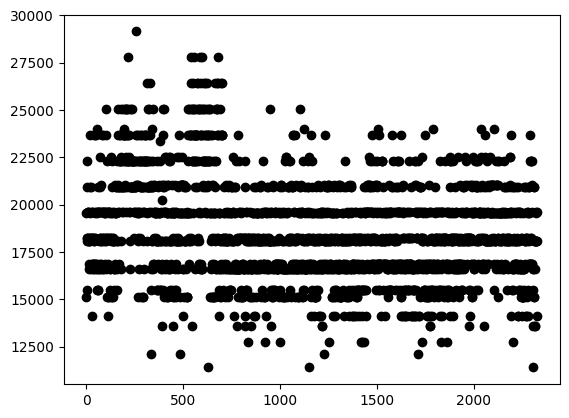

In [135]:
compute_vec_stats(vecLengths)

In [132]:
np.where(vecLengths == 56448.0)
print(len(data_dictionary['soundVec'][13]))
print(data_dictionary['ipa'][13])
print(data_dictionary['syllables'][13])
print(data_dictionary['stress'][13])
print(data_dictionary['audio_urls'][13])
data_dictionary['soundVec'][13] = np.nan
data_dictionary['ipa'][13] = np.nan
data_dictionary['syllables'][13] = np.nan
data_dictionary['stress'][13] = np.nan
data_dictionary['audio_urls'][13] = np.nan
v = {'soundVec':[],'ipa':[],'syllables':[], 'stress':[], 'audio_urls':[]}
for i in range(len(data_dictionary['soundVec']) - 1):
  if(i < 13):
    v['soundVec'].append(data_dictionary['soundVec'][i])
    v['ipa'].append(data_dictionary['ipa'][i])
    v['syllables'].append(data_dictionary['syllables'][i])
    v['stress'].append(data_dictionary['stress'][i])
    v['audio_urls'].append(data_dictionary['audio_urls'][i])
  else:
    v['soundVec'].append(data_dictionary['soundVec'][i + 1])
    v['ipa'].append(data_dictionary['ipa'][i + 1])
    v['syllables'].append(data_dictionary['syllables'][i + 1])
    v['stress'].append(data_dictionary['stress'][i + 1])
    v['audio_urls'].append(data_dictionary['audio_urls'][i + 1])
data_dictionary = v

56448
ˈʔab.ʕad
2.0
1.0
https://upload.wikimedia.org/wikipedia/commons/7/7f/LL-Q55633582_%28ajp%29-Mohammad-LPA-%D9%84%D8%A7%D8%B2%D9%85_%D8%A3%D8%A8%D8%B9%D8%AF_%D8%B9%D9%86_%D8%A7%D9%84%D8%AA%D9%84%D9%81%D9%88%D9%86_%E2%80%94_%D9%87%D9%8A%D9%83_%D8%B9%D9%85%D8%B1%D9%8A_%D9%85%D8%A7_%D8%A8%D8%B9%D9%85%D9%84_%D8%A5%D8%B4%D9%8A.wav


In [136]:
pad_size = 25000
print(data_dictionary['ipa'][13])
print(data_dictionary['syllables'][13])
print(data_dictionary['stress'][13])
print(data_dictionary['audio_urls'][13])

ˈʔab.ban
2.0
1.0
https://upload.wikimedia.org/wikipedia/commons/8/8c/LL-Q55633582_%28ajp%29-Khalil.rantissi-%D8%A3%D8%A8%D9%8E%D9%91%D9%86.wav


In [138]:
def generate_padded_audio_vector(vector, size):
  """
  takes in the data frame and returns an array representing the audio vectors,
  each of the size specified. The audio package from whisper is used to generate, and pad or trim
  the vectors.
  """
  try:
    padded_vector = audio.pad_or_trim(vector, size)
  except Exception:
      print('error with padding the vector')
      return
  return padded_vector

def generate_data(dictionary, size):
  '''
  takes the dictionary and generates a fixed length matrix which will be used
  for machine learning.
  '''
  data = {'soundVec':np.ndarray((len(dictionary['soundVec']), size)), 'ipa':[],
          'syllables':[], 'stress':[], 'audio_urls':[]}
  for i in range(len(dictionary['soundVec'])):
    padded_vector = generate_padded_audio_vector(dictionary['soundVec'][i], size)
    data['soundVec'][i,:] = padded_vector
    data['ipa'].append(dictionary['ipa'][i])
    data['syllables'].append(dictionary['syllables'][i])
    data['stress'].append(dictionary['stress'][i])
    data['audio_urls'].append(dictionary['audio_urls'][i])
  return data





In [139]:
data_dictionary = generate_data(data_dictionary, pad_size)

In [140]:

print(data_dictionary['soundVec'].shape)
print(len(data_dictionary['ipa']))

(2327, 25000)
2327


In [141]:
def visualize(vector):
  """
  takes the vector, which by assumption is of an audio representation,
  then displays its wave information, along with its spectrogram.
  """
  fig, axes1 = plt.subplots()
  fig, axes2 = plt.subplots()
  axes1.plot(vector, '-')
  axes2.specgram(vector)

[0.00027466 0.00030518 0.00033569 ... 0.         0.         0.        ]
(25000,)
2.0
muˈriːħ


/usr/local/lib/python3.12/dist-packages/matplotlib/axes/_axes.py:8233: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


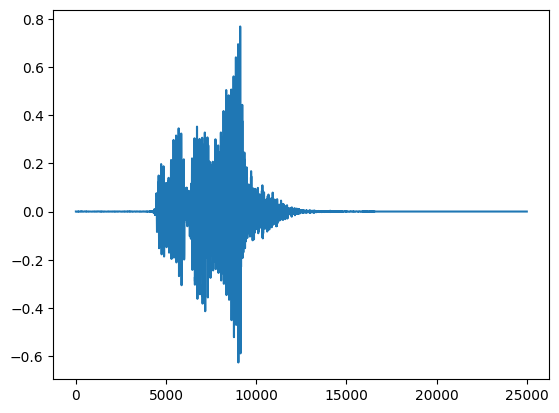

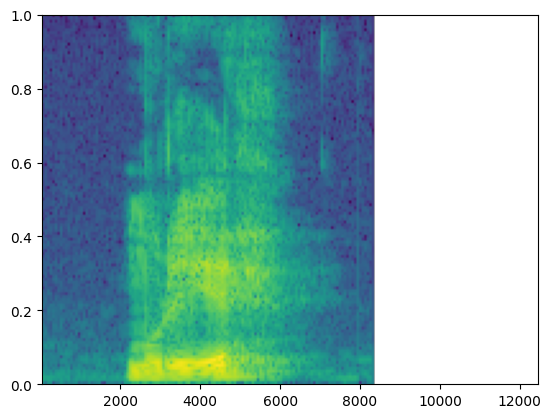

In [142]:
i = 2000
print(data_dictionary['soundVec'][i])
print(data_dictionary['soundVec'][i].shape)
print(data_dictionary['stress'][i])
print(data_dictionary['ipa'][i])
visualize(data_dictionary['soundVec'][i])

In [143]:
data = {'X':np.ndarray((2327,25001)), 'Y':np.ndarray(2327,)}
for i in range(len(data_dictionary['soundVec'])):
  data['X'][i,:25000] = data_dictionary['soundVec'][i]
  data['X'][i, 25000] = data_dictionary['syllables'][i]
  data['Y'][i] = data_dictionary['stress'][i]


In [144]:
X_train, X_test, Y_train, Y_test = train_test_split(data['X'], data['Y'], test_size=.2)

In [145]:
X_test, X_dev, Y_test, Y_dev = train_test_split(X_test, Y_test, test_size=.5)

#Machine learning Stage










In [146]:
from sklearn.linear_model import LogisticRegression

In [147]:
LR = LogisticRegression(max_iter=1000, solver='lbfgs')
LR.fit(X_train, Y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(max_iter=1000, multi_class='multinomial')

In [148]:
print(LR.classes_)
print(LR.coef_)
print(LR.coef_.shape)
print(LR.n_features_in_)
print(LR.n_iter_)


[1. 2. 3. 4.]
[[-4.65575150e-04  2.04359278e-04  7.30107302e-04 ...  1.53791632e-05
   7.77014331e-06 -3.32920174e+00]
 [ 6.98790843e-04  3.29550513e-06 -3.85210970e-04 ...  1.93081710e-05
   2.74766708e-06  1.31874682e+00]
 [-2.31446546e-04 -2.09355853e-04 -3.49307796e-04 ... -3.48567309e-05
  -1.06106530e-05  2.15170970e+00]
 [-1.76914708e-06  1.70107044e-06  4.41146394e-06 ...  1.69396754e-07
   9.28426173e-08 -1.41254781e-01]]
(4, 25001)
25001
[69]


In [151]:
probs = LR.predict_proba(X_dev)
stress1, stress2, stress3, stress4 = probs[:,0],probs[:,1],probs[:,2],probs[:,3]
X_dev_predictions = LR.predict(X_dev)
d = {'stress1':stress1, 'stress2':stress2, 'stress3':stress3, 'stress4':stress4,
     'X_dev predictions':X_dev_predictions, 'True X_dev value':Y_dev}
results_analysis = pd.DataFrame(d,index=list(range(len(X_dev))))

In [152]:
print('Score: ', LR.score(X_dev, Y_dev))
results_analysis.head(20)


Score:  0.6609442060085837


,stress1,stress2,stress3,stress4,X_dev predictions,True X_dev value
0,0.997824,0.002152,0.000012,0.000012,1.0,1.0
1,0.008172,0.990592,0.001169,0.000067,2.0,1.0
2,0.999837,0.000148,0.000011,0.000004,1.0,1.0
3,0.985694,0.013904,0.000354,0.000047,1.0,1.0
4,0.947025,0.052743,0.000158,0.000074,1.0,1.0
5,0.023863,0.889932,0.085984,0.000221,2.0,1.0
6,0.258878,0.738639,0.002185,0.000298,2.0,1.0
7,0.899930,0.099220,0.000739,0.000111,1.0,1.0
8,0.987074,0.012588,0.000290,0.000048,1.0,1.0
9,0.996555,0.001348,0.002041,0.000055,1.0,2.0


In [153]:
results_analysis.tail(20)

,stress1,stress2,stress3,stress4,X_dev predictions,True X_dev value
213,0.967850,0.030613,0.001398,1.381817e-04,1.0,1.0
214,0.998314,0.001603,0.000068,1.485561e-05,1.0,1.0
215,0.989383,0.010200,0.000362,5.440970e-05,1.0,1.0
216,0.022293,0.977298,0.000340,6.940148e-05,2.0,1.0
217,0.955786,0.042933,0.001160,1.213469e-04,1.0,1.0
218,0.999993,0.000003,0.000004,8.714077e-07,1.0,1.0
219,0.996901,0.003057,0.000026,1.565739e-05,1.0,2.0
220,0.022823,0.977012,0.000112,5.296736e-05,2.0,2.0
221,0.358697,0.637022,0.003936,3.457856e-04,2.0,1.0
222,0.997788,0.002054,0.000135,2.204242e-05,1.0,1.0


In [154]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_dev, X_dev_predictions)

array([[117,  29,   0],
       [ 42,  37,   0],
       [  1,   7,   0]])